In [17]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance, ks_2samp, entropy

def mfm(file1, file2):
    # Load data
    df1 = pd.read_csv(file1, header=0, names=['True_Label', 'Predicted_Score'])
    df2 = pd.read_csv(file2, header=0, names=['True_Label', 'Predicted_Score'])

    # Extract predicted scores and true labels
    preds1 = df1['Predicted_Score'].values
    preds2 = df2['Predicted_Score'].values
    true_labels = df1['True_Label'].values

    # 1. Wasserstein Distance (Earth Mover's Distance)
    D_Wass = wasserstein_distance(preds1, preds2)

    # 2. KL Divergence (between true distribution and predicted distribution)
    def safe_kl_div(p, q):
        p = p / p.sum()
        q = q / q.sum()
        p = p + 1e-10  # avoid log(0)
        q = q + 1e-10
        return entropy(p, q)

    # Create histogram-based distributions
    true_dist, _ = np.histogram(true_labels, bins=100, density=True)
    dist1, _ = np.histogram(preds1, bins=100, density=True)
    dist2, _ = np.histogram(preds2, bins=100, density=True)

    D_KL = safe_kl_div(true_dist, dist1) - safe_kl_div(true_dist, dist2)

    # 3. KS Statistic
    D_KS, _ = ks_2samp(preds1, preds2)

    # 4. Composite CSV-M metric
    CSV_M = (D_Wass + D_KL + D_KS) / 3

    # Output results
    print(f"Wasserstein Distance: {D_Wass:.4f}")
    print(f"KL Divergence Shift: {D_KL:.4f}")
    print(f"KS Statistic: {D_KS:.4f}")
    print(f"Cold-Start Vulnerability Metric (CSV-M): {CSV_M:.4f}")

In [20]:
#Single Protein Blinded
print("PROTEIN 1")
mfm('results/1_21/predictions_GINConvNet_davis.csv', 'davis_blinding/predictions_GINConvNet_davis_b.csv')
print("PROTEIN 2")
mfm('results/1_21/predictions_GINConvNet_davis.csv', 'davis_blinding/predictions_GINConvNet_davis_b2.csv')

PROTEIN 1
Wasserstein Distance: 0.3350
KL Divergence Shift: 0.8890
KS Statistic: 0.5837
Cold-Start Vulnerability Metric (CSV-M): 0.6026
PROTEIN 2
Wasserstein Distance: 0.1890
KL Divergence Shift: 0.8913
KS Statistic: 0.3836
Cold-Start Vulnerability Metric (CSV-M): 0.4880


In [21]:
#20% Blinded	b3 vs. DAVIS
mfm("results/1_21/predictions_GINConvNet_davis.csv", "davis_blinding/predictions_GINConvNet_davis_b3.csv")

Wasserstein Distance: 0.2327
KL Divergence Shift: 1.5513
KS Statistic: 0.3444
Cold-Start Vulnerability Metric (CSV-M): 0.7095


In [22]:
#Pharos full vs. DAVIS
mfm("results/1_21/predictions_GINConvNet_davis.csv", "pharos_full/predictions_pharos_full.csv")

Wasserstein Distance: 2.2394
KL Divergence Shift: -4.4349
KS Statistic: 0.8233
Cold-Start Vulnerability Metric (CSV-M): -0.4574


In [23]:
#Pharos reclass vs. DAVIS
mfm("results/1_21/predictions_GINConvNet_davis.csv", "results/1_21/predictions_pharos_reclass.csv")

Wasserstein Distance: 0.4709
KL Divergence Shift: 0.2044
KS Statistic: 0.2308
Cold-Start Vulnerability Metric (CSV-M): 0.3020


# MADD

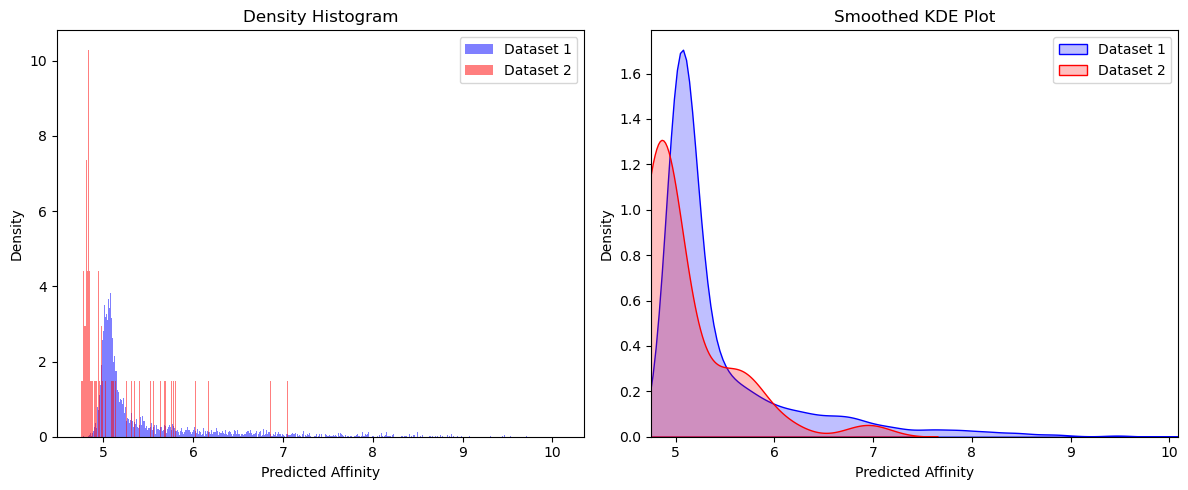

MADD: 162.9440


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_density_difference(df1, df2, e=0.01):
    preds_1 = np.round(df1['Predicted_Value'] / e) * e
    preds_2 = np.round(df2['Predicted_Value'] / e) * e
    
    # Get the min and max range of the predictions for appropriate binning
    min_pred = min(np.min(preds_1), np.min(preds_2))
    max_pred = max(np.max(preds_1), np.max(preds_2))
    
    # Create bins based on the prediction range
    bins = np.arange(min_pred, max_pred + e, e)
    
    density_1, _ = np.histogram(preds_1, bins=bins, density=True)
    density_2, _ = np.histogram(preds_2, bins=bins, density=True)
    
    # Compute MADD (Mean Absolute Density Difference)
    madd = np.sum(np.abs(density_1 - density_2))
    
    # Plot histograms
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(preds_1, bins=bins, alpha=0.5, label='Dataset 1', color='blue', density=True)
    plt.hist(preds_2, bins=bins, alpha=0.5, label='Dataset 2', color='red', density=True)
    plt.title('Density Histogram')
    plt.xlabel('Predicted Affinity')
    plt.ylabel('Density')
    plt.legend()
    
    # Plot KDE curves
    plt.subplot(1, 2, 2)
    sns.kdeplot(df1['Predicted_Value'], bw_method='scott', label='Dataset 1', color='blue', fill=True)
    sns.kdeplot(df2['Predicted_Value'], bw_method='scott', label='Dataset 2', color='red', fill=True)
    plt.title('Smoothed KDE Plot')
    plt.xlabel('Predicted Affinity')
    plt.ylabel('Density')
    plt.legend()
    
    # Dynamically set the x-axis limits based on the range of predictions
    plt.subplot(1, 2, 2)
    plt.xlim(min_pred, max_pred)
    
    plt.tight_layout()
    plt.show()
    
    return madd

# Read data
df1 = pd.read_csv("results/1_21/predictions_GINConvNet_davis.csv", header=0, names=['True_Label', 'Predicted_Value'])
df2 = pd.read_csv("davis_blinding/predictions_GINConvNet_davis_b.csv", header=0, names=['True_Label', 'Predicted_Value'])

# Compute and print MADD
madd = compute_density_difference(df1, df2)
print(f"MADD: {madd:.4f}")


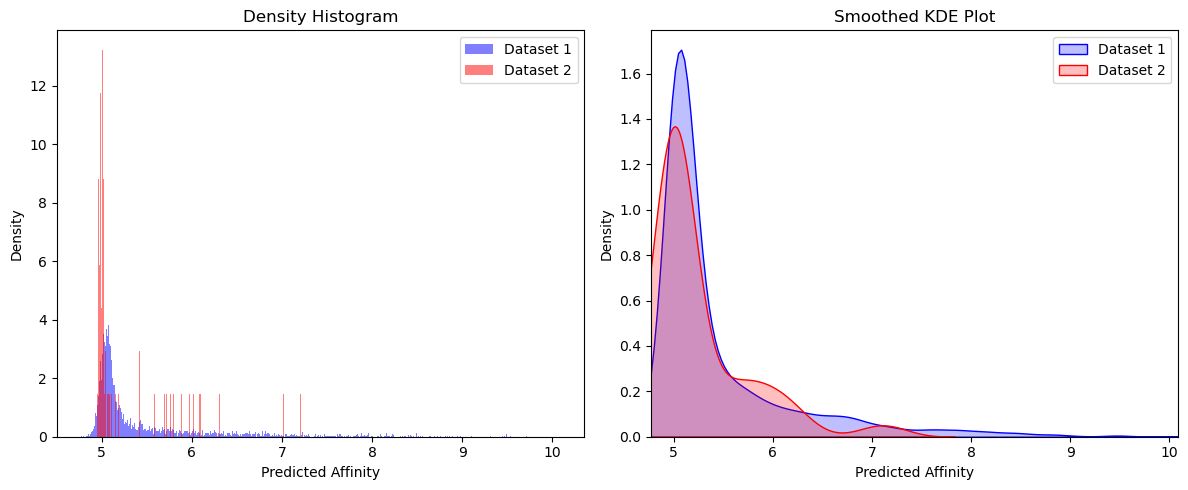

MADD: 128.2677


In [15]:
df1 = pd.read_csv("results/1_21/predictions_GINConvNet_davis.csv", header=0, names=['True_Label', 'Predicted_Value'])
df2 = pd.read_csv("davis_blinding/predictions_GINConvNet_davis_b2.csv", header=0, names=['True_Label', 'Predicted_Value'])

# Compute and print MADD
madd = compute_density_difference(df1, df2)
print(f"MADD: {madd:.4f}")


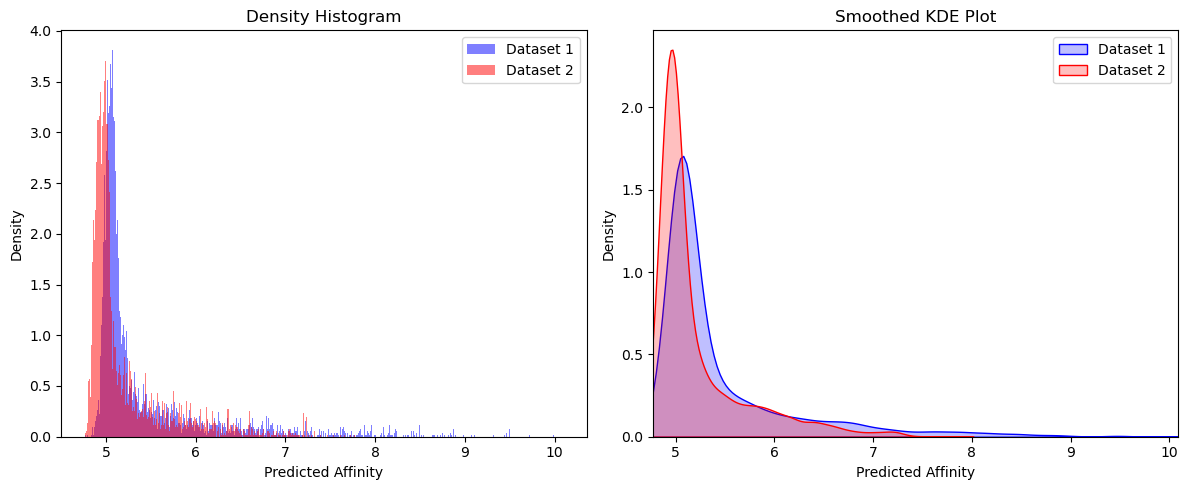

MADD: 81.3982


In [16]:
df1 = pd.read_csv("results/1_21/predictions_GINConvNet_davis.csv", header=0, names=['True_Label', 'Predicted_Value'])
df2 = pd.read_csv("davis_blinding/predictions_GINConvNet_davis_b3.csv", header=0, names=['True_Label', 'Predicted_Value'])

# Compute and print MADD
madd = compute_density_difference(df1, df2)
print(f"MADD: {madd:.4f}")


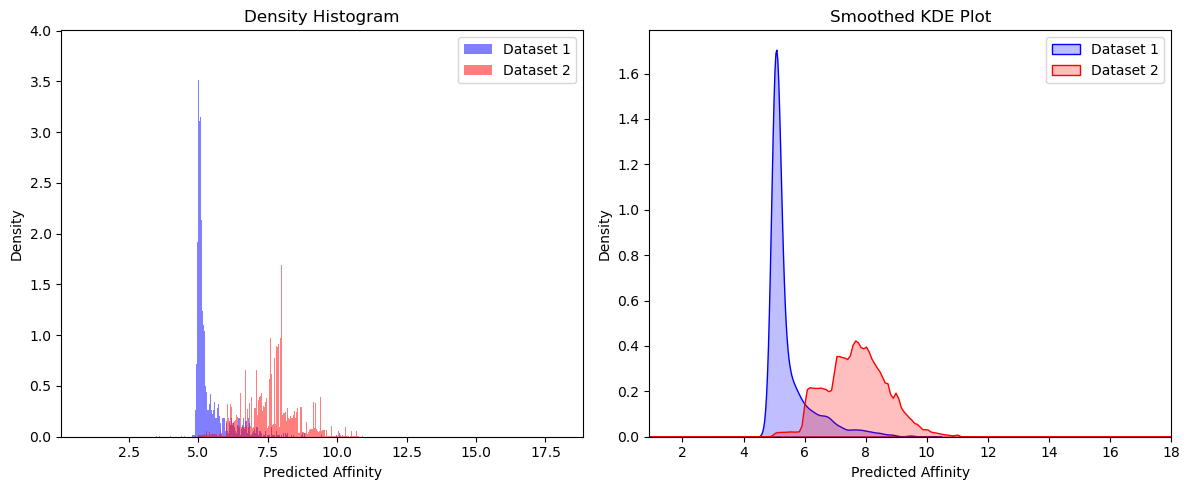

MADD: 166.6999


In [5]:
# Read data
df1 = pd.read_csv("results/1_21/predictions_GINConvNet_davis.csv", header=0, names=['True_Label', 'Predicted_Value'])
df2 = pd.read_csv("pharos_full/predictions_pharos_full.csv", header=0, names=['True_Label', 'Predicted_Value'])

# Compute and print MADD
madd = compute_density_difference(df1, df2)
print(f"MADD: {madd:.4f}")

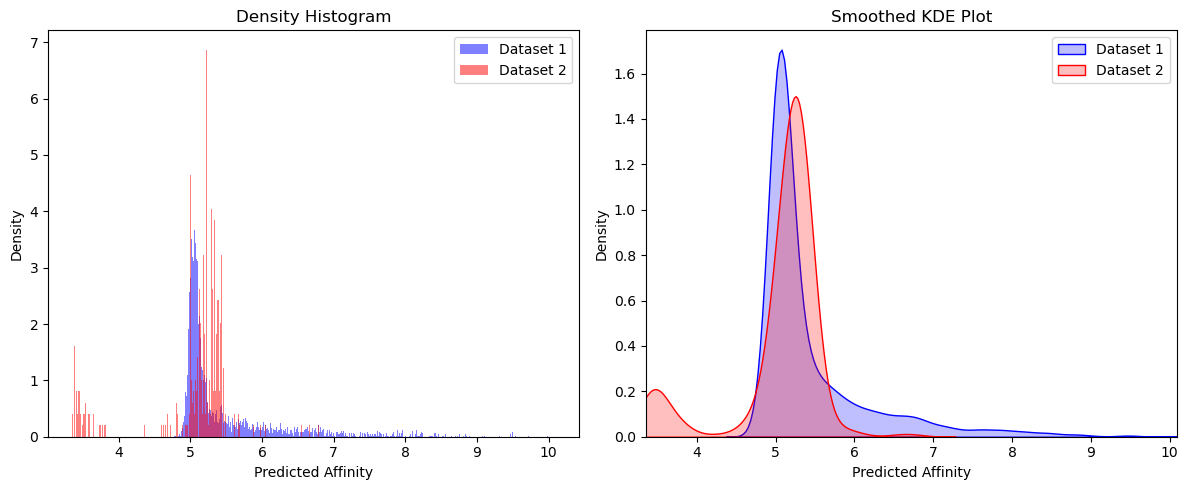

MADD: 127.2377


In [14]:
# Read data
df1 = pd.read_csv("results/1_21/predictions_GINConvNet_davis.csv", header=0, names=['True_Label', 'Predicted_Value'])
df2 = pd.read_csv("results/1_21/predictions_pharos_reclass.csv", header=0, names=['True_Label', 'Predicted_Value'])

# Compute and print MADD
madd = compute_density_difference(df1, df2)
print(f"MADD: {madd:.4f}")